In [25]:
import numpy as np
import scipy as sp
import math
import torch
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import optuna
import functools
from sklearn.model_selection import KFold
import time

from typing import Callable
from torch import nn, optim
from data import diffeq, create_trainig_test_set, create_trainig_validation_test_set

import torch.nn.functional as F

In [3]:
#Define the harmonic oscillator

def f(t,x,k):
    #write the function that is on the other side of the differential equation
    return -k*x

def differential_equation_1_order(t, x, k):
    dx_dt = f(t,x,k)
    return dx_dt

def differential_equation_2_order(t, X, k):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,k)

    return [dx_dt, dy_dt]

In [4]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"
print(device)


cpu


# Model definition

In [5]:
torch.manual_seed(0) #get the same random numbers everytime you run the code
harmonic_osc = diffeq(differential_equation_2_order, 2, 1)

t_span = (0, 10) #wanted timespan
n_step = 100 #number of steps to train the data (number of initial conditions)
n_data = 1000 #number of data per step (per initial condition, this number of datapoints to train, validate, test data)

#validation set will be used to choose hyperparameters, decide when to stop training, compare multiple models fairly and detect overfitting
train, validation, test = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1000, [0.5, 0.2, 0.3], "RK45", device=device, seed=0)

In [6]:
class HarmonicModel(nn.Module):
    def __init__(self, n_in, hidden_sizes, activation):
        super().__init__()
        act = {
            'tanh': nn.Tanh(),
            'sine': torch.sin,
            'gelu': nn.GELU(),
            'relu': nn.ReLU()
        }

        #allow for different sizes of neurons for each layer
        layer_sizes = [n_in] + hidden_sizes + [1] #becomes for example [4, 64, 32, 16, 1]
        
        self.net = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i+1])
            for i in range(len(layer_sizes)-1)
        ]) #nn.Linear(4, 64), nn.Linear(64, 32), ..., nn.Linear(16, 1)

        self.activation = act[activation] #chooses a value from the dictionary, e.g. act['tanh']

    def forward(self, x):
        for layer in self.net[:-1]:
            if callable(self.activation):  # sine special case
                x = self.activation(layer(x))
            else:
                x = self.activation(layer(x))
        return self.net[-1](x)

# test model
model = HarmonicModel(
    n_in=4,
    hidden_sizes=[64, 32, 16],   # ← arbitrary shapes
    activation='tanh'
).to(device)

In [7]:
def loss_harmonic(y_pred, y_exp, x_00, x_01, t, k, N_f):
    mse_y = torch.mean((y_pred - y_exp)**2)
    
    return mse_y

In [8]:
#train model
def train_harmonic(model, lr, epochs, data):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X = data["X"]
    y_exp = data["y_tensor"][0:, 0:, 0].to(device)
    
    t = X[0:, 0:, 3]
    k = X[0:, 0:, 0]
    x_00 = X[0:, 0:, 1]
    x_01 = X[0:, 0:, 2]

    for epoch in range(epochs):
        y_pred = model(X).squeeze(-1)
        loss = loss_harmonic(y_pred, y_exp, x_00, x_01, t, k, N_f=1000)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % (int(epochs)) == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    return model #return trained model, not final loss

#evaluate model
def evaluate_harmonic(model, data):
    model.eval()
    X_val = data["X"].to(device)
    y_val = data["y_tensor"][:, :, 0].to(device)

    t = X_val[:, :, 3]
    k = X_val[:, :, 0]
    x_00 = X_val[:, :, 1]
    x_01 = X_val[:, :, 2]

    with torch.no_grad():
        y_pred = model(X_val).squeeze(-1)
        loss = loss_harmonic(y_pred, y_val, x_00, x_01, t, k, N_f=1000)

    return loss.item()

# Hyperparameter optimization

## 1) Using random hyperparameter search

In [ ]:
def rng_hparameters_search(n_trials, layers_i: tuple, neurons_i: tuple, activations_l: list, lr_i: tuple, train_data, val_data, seed=0, device='cpu'):
    torch.manual_seed(seed)
    random.seed(seed)
    result = []

    for _ in tqdm(range(n_trials), desc="Hyperparameter search"):
        n_layers = random.randint(layers_i[0], layers_i[1])  # inclusive

        hidden_sizes = [
            random.randint(neurons_i[0], neurons_i[1])
            for _ in range(n_layers)
        ]

        activation = random.choice(activations_l)

        lr = 10 ** random.uniform(
            torch.log10(torch.tensor(lr_i[0])).item(),
            torch.log10(torch.tensor(lr_i[1])).item()
        )

        params = {
            'hidden_sizes': hidden_sizes,
            'activation': activation,
            'lr': lr
        }

        model = HarmonicModel(n_in=4, hidden_sizes=hidden_sizes, activation=activation).to(device)
        #train_model
        train_harmonic(model, lr=lr, epochs=100, data=train_data)

        #evaluate on validation data
        val_loss = evaluate_harmonic(model,data=val_data)

        result.append((params, val_loss))
    
    return result

In [10]:
n_trials = 50
results_opt_rand = rng_hparameters_search(n_trials,
                                 layers_i=(2, 5),
                                 neurons_i=(16, 128),
                                 activations_l=['tanh', 'sine', 'gelu', 'relu'],
                                 lr_i= (1e-4, 1e-2),
                                 train_data = train,
                                 val_data = validation, 
                                 device=device,
                                 seed=0)

Hyperparameter search:   0%|          | 0/50 [00:00<?, ?it/s]

Hyperparameter search:   2%|▏         | 1/50 [00:10<08:35, 10.53s/it]

Epoch 100/100, Loss: 0.4193


Hyperparameter search:   4%|▍         | 2/50 [00:19<07:43,  9.65s/it]

Epoch 100/100, Loss: 0.6146


Hyperparameter search:   6%|▌         | 3/50 [00:30<07:55, 10.12s/it]

Epoch 100/100, Loss: 0.1388


Hyperparameter search:   8%|▊         | 4/50 [00:38<07:14,  9.44s/it]

Epoch 100/100, Loss: 0.3423


Hyperparameter search:  10%|█         | 5/50 [00:47<06:55,  9.24s/it]

Epoch 100/100, Loss: 0.5449


Hyperparameter search:  12%|█▏        | 6/50 [00:58<07:05,  9.66s/it]

Epoch 100/100, Loss: 0.8022


Hyperparameter search:  14%|█▍        | 7/50 [01:02<05:40,  7.92s/it]

Epoch 100/100, Loss: 0.5403


Hyperparameter search:  16%|█▌        | 8/50 [01:09<05:24,  7.73s/it]

Epoch 100/100, Loss: 0.7056


Hyperparameter search:  18%|█▊        | 9/50 [01:27<07:23, 10.81s/it]

Epoch 100/100, Loss: 0.5895


Hyperparameter search:  20%|██        | 10/50 [01:41<07:51, 11.79s/it]

Epoch 100/100, Loss: 0.7461


Hyperparameter search:  22%|██▏       | 11/50 [01:53<07:45, 11.95s/it]

Epoch 100/100, Loss: 0.1590


Hyperparameter search:  24%|██▍       | 12/50 [01:58<06:17,  9.92s/it]

Epoch 100/100, Loss: 0.1521


Hyperparameter search:  26%|██▌       | 13/50 [02:10<06:30, 10.55s/it]

Epoch 100/100, Loss: 0.5428


Hyperparameter search:  28%|██▊       | 14/50 [02:15<05:16,  8.80s/it]

Epoch 100/100, Loss: 0.7738


Hyperparameter search:  30%|███       | 15/50 [02:21<04:41,  8.05s/it]

Epoch 100/100, Loss: 0.1749


Hyperparameter search:  32%|███▏      | 16/50 [02:26<03:57,  6.98s/it]

Epoch 100/100, Loss: 0.3524


Hyperparameter search:  34%|███▍      | 17/50 [02:44<05:39, 10.30s/it]

Epoch 100/100, Loss: 0.0354


Hyperparameter search:  36%|███▌      | 18/50 [02:58<06:06, 11.47s/it]

Epoch 100/100, Loss: 0.8370


Hyperparameter search:  38%|███▊      | 19/50 [03:04<05:03,  9.78s/it]

Epoch 100/100, Loss: 0.1378


Hyperparameter search:  40%|████      | 20/50 [03:10<04:22,  8.75s/it]

Epoch 100/100, Loss: 0.5790


Hyperparameter search:  42%|████▏     | 21/50 [03:22<04:42,  9.74s/it]

Epoch 100/100, Loss: 0.7464


Hyperparameter search:  44%|████▍     | 22/50 [03:33<04:40, 10.00s/it]

Epoch 100/100, Loss: 0.3026


Hyperparameter search:  46%|████▌     | 23/50 [03:35<03:26,  7.66s/it]

Epoch 100/100, Loss: 0.6155


Hyperparameter search:  48%|████▊     | 24/50 [03:38<02:41,  6.21s/it]

Epoch 100/100, Loss: 0.2756


Hyperparameter search:  50%|█████     | 25/50 [03:41<02:12,  5.29s/it]

Epoch 100/100, Loss: 0.7872


Hyperparameter search:  52%|█████▏    | 26/50 [03:47<02:09,  5.41s/it]

Epoch 100/100, Loss: 0.2517


Hyperparameter search:  54%|█████▍    | 27/50 [03:50<01:49,  4.74s/it]

Epoch 100/100, Loss: 0.6343


Hyperparameter search:  56%|█████▌    | 28/50 [03:56<01:49,  5.00s/it]

Epoch 100/100, Loss: 0.6680


Hyperparameter search:  58%|█████▊    | 29/50 [04:01<01:49,  5.24s/it]

Epoch 100/100, Loss: 0.6330


Hyperparameter search:  60%|██████    | 30/50 [04:16<02:39,  7.96s/it]

Epoch 100/100, Loss: 0.4915


Hyperparameter search:  62%|██████▏   | 31/50 [04:24<02:34,  8.14s/it]

Epoch 100/100, Loss: 0.1686


Hyperparameter search:  64%|██████▍   | 32/50 [04:32<02:24,  8.05s/it]

Epoch 100/100, Loss: 0.2207


Hyperparameter search:  66%|██████▌   | 33/50 [04:38<02:04,  7.32s/it]

Epoch 100/100, Loss: 0.2600


Hyperparameter search:  68%|██████▊   | 34/50 [04:49<02:18,  8.65s/it]

Epoch 100/100, Loss: 0.7736


Hyperparameter search:  70%|███████   | 35/50 [04:56<01:58,  7.87s/it]

Epoch 100/100, Loss: 0.6534


Hyperparameter search:  72%|███████▏  | 36/50 [05:01<01:38,  7.03s/it]

Epoch 100/100, Loss: 0.6686


Hyperparameter search:  74%|███████▍  | 37/50 [05:17<02:07,  9.80s/it]

Epoch 100/100, Loss: 0.2806


Hyperparameter search:  76%|███████▌  | 38/50 [05:32<02:17, 11.48s/it]

Epoch 100/100, Loss: 0.3831


Hyperparameter search:  78%|███████▊  | 39/50 [05:39<01:51, 10.13s/it]

Epoch 100/100, Loss: 0.5180


Hyperparameter search:  80%|████████  | 40/50 [05:59<02:09, 12.95s/it]

Epoch 100/100, Loss: 0.1963


Hyperparameter search:  82%|████████▏ | 41/50 [06:03<01:32, 10.26s/it]

Epoch 100/100, Loss: 0.7696


Hyperparameter search:  84%|████████▍ | 42/50 [06:11<01:18,  9.77s/it]

Epoch 100/100, Loss: 0.4172


Hyperparameter search:  86%|████████▌ | 43/50 [06:23<01:11, 10.21s/it]

Epoch 100/100, Loss: 0.7858


Hyperparameter search:  88%|████████▊ | 44/50 [06:34<01:04, 10.68s/it]

Epoch 100/100, Loss: 0.1378


Hyperparameter search:  90%|█████████ | 45/50 [06:58<01:12, 14.60s/it]

Epoch 100/100, Loss: 0.1076


Hyperparameter search:  92%|█████████▏| 46/50 [07:10<00:55, 13.91s/it]

Epoch 100/100, Loss: 0.7045


Hyperparameter search:  94%|█████████▍| 47/50 [07:23<00:40, 13.65s/it]

Epoch 100/100, Loss: 0.6853


Hyperparameter search:  96%|█████████▌| 48/50 [07:33<00:25, 12.56s/it]

Epoch 100/100, Loss: 0.3896


Hyperparameter search:  98%|█████████▊| 49/50 [07:48<00:13, 13.13s/it]

Epoch 100/100, Loss: 0.7763


Hyperparameter search: 100%|██████████| 50/50 [07:54<00:00,  9.48s/it]

Epoch 100/100, Loss: 0.7759


## 2) Using Bayesian hyperparameter search

In [11]:
# Define your hyperparameter ranges and data
layers_i = (2, 5)
neurons_i = (4, 128)
activations_l = ['tanh', 'sine', 'gelu', 'relu']
lr_i = (1e-4, 1e-2)
train_data = train
val_data   = validation
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def objective(trial, layers_i, neurons_i, activations_l, lr_i, train_data, val_data):
    n_layers = trial.suggest_int("n_layers", layers_i[0], layers_i[1])
    hidden_sizes = [trial.suggest_int(f"neurons_l{i}", neurons_i[0], neurons_i[1]) for i in range(n_layers)]
    activation = trial.suggest_categorical("activation", activations_l)
    lr = trial.suggest_float("lr", lr_i[0], lr_i[1], log=True)


    model = HarmonicModel(n_in=4, hidden_sizes=hidden_sizes, activation=activation).to(device)

    #train model
    train_harmonic(model, lr=lr, epochs=100, data=train_data)

    #evaluate model
    val_loss = evaluate_harmonic(model, data=val_data)

    return val_loss

# Use functools.partial to pass extra arguments
objective_fixed = functools.partial(objective,
                                    layers_i=layers_i,
                                    neurons_i=neurons_i,
                                    activations_l=activations_l,
                                    lr_i=lr_i,
                                    train_data=train_data,
                                    val_data=val_data
                                    )

study = optuna.create_study(direction="minimize")
study.optimize(objective_fixed, n_trials=50)


[I 2025-12-05 08:48:12,302] A new study created in memory with name: no-name-60df145d-84aa-4e79-a8ba-2827fc6bf53e
[I 2025-12-05 08:48:21,440] Trial 0 finished with value: 0.2734842002391815 and parameters: {'n_layers': 3, 'neurons_l0': 115, 'neurons_l1': 68, 'neurons_l2': 7, 'activation': 'tanh', 'lr': 0.008573921264614183}. Best is trial 0 with value: 0.2734842002391815.


Epoch 100/100, Loss: 0.2776


[I 2025-12-05 08:48:47,308] Trial 1 finished with value: 0.39245137572288513 and parameters: {'n_layers': 5, 'neurons_l0': 108, 'neurons_l1': 103, 'neurons_l2': 126, 'neurons_l3': 98, 'neurons_l4': 102, 'activation': 'relu', 'lr': 0.0004400631308892112}. Best is trial 0 with value: 0.2734842002391815.


Epoch 100/100, Loss: 0.3960


[I 2025-12-05 08:48:51,970] Trial 2 finished with value: 0.8387380838394165 and parameters: {'n_layers': 3, 'neurons_l0': 20, 'neurons_l1': 29, 'neurons_l2': 99, 'activation': 'gelu', 'lr': 0.0003511484352144738}. Best is trial 0 with value: 0.2734842002391815.


Epoch 100/100, Loss: 0.8278


[I 2025-12-05 08:48:54,683] Trial 3 finished with value: 0.10574203729629517 and parameters: {'n_layers': 3, 'neurons_l0': 97, 'neurons_l1': 30, 'neurons_l2': 41, 'activation': 'relu', 'lr': 0.0073094100805389944}. Best is trial 3 with value: 0.10574203729629517.


Epoch 100/100, Loss: 0.1081


[I 2025-12-05 08:48:57,914] Trial 4 finished with value: 0.6774553656578064 and parameters: {'n_layers': 3, 'neurons_l0': 4, 'neurons_l1': 30, 'neurons_l2': 47, 'activation': 'sine', 'lr': 0.004103774878463513}. Best is trial 3 with value: 0.10574203729629517.


Epoch 100/100, Loss: 0.6617


[I 2025-12-05 08:49:04,536] Trial 5 finished with value: 0.5644292235374451 and parameters: {'n_layers': 3, 'neurons_l0': 81, 'neurons_l1': 20, 'neurons_l2': 103, 'activation': 'relu', 'lr': 0.0011714045491381414}. Best is trial 3 with value: 0.10574203729629517.


Epoch 100/100, Loss: 0.5527


[I 2025-12-05 08:49:10,516] Trial 6 finished with value: 0.5585339069366455 and parameters: {'n_layers': 3, 'neurons_l0': 99, 'neurons_l1': 16, 'neurons_l2': 49, 'activation': 'relu', 'lr': 0.0008567401347238095}. Best is trial 3 with value: 0.10574203729629517.


Epoch 100/100, Loss: 0.5459


[I 2025-12-05 08:49:23,894] Trial 7 finished with value: 0.5112646818161011 and parameters: {'n_layers': 4, 'neurons_l0': 26, 'neurons_l1': 125, 'neurons_l2': 99, 'neurons_l3': 14, 'activation': 'gelu', 'lr': 0.0007905327751621371}. Best is trial 3 with value: 0.10574203729629517.


Epoch 100/100, Loss: 0.4781


[I 2025-12-05 08:49:26,954] Trial 8 finished with value: 0.8943944573402405 and parameters: {'n_layers': 2, 'neurons_l0': 127, 'neurons_l1': 7, 'activation': 'gelu', 'lr': 0.00010787713064461199}. Best is trial 3 with value: 0.10574203729629517.


Epoch 100/100, Loss: 0.8952


[I 2025-12-05 08:49:31,526] Trial 9 finished with value: 0.7288551926612854 and parameters: {'n_layers': 2, 'neurons_l0': 101, 'neurons_l1': 18, 'activation': 'sine', 'lr': 0.0003637281304601218}. Best is trial 3 with value: 0.10574203729629517.


Epoch 100/100, Loss: 0.7260


[I 2025-12-05 08:49:39,773] Trial 10 finished with value: 0.2379084974527359 and parameters: {'n_layers': 4, 'neurons_l0': 57, 'neurons_l1': 56, 'neurons_l2': 5, 'neurons_l3': 124, 'activation': 'tanh', 'lr': 0.0034681516983769505}. Best is trial 3 with value: 0.10574203729629517.


Epoch 100/100, Loss: 0.2548


[I 2025-12-05 08:49:47,042] Trial 11 finished with value: 0.21975195407867432 and parameters: {'n_layers': 4, 'neurons_l0': 58, 'neurons_l1': 60, 'neurons_l2': 5, 'neurons_l3': 126, 'activation': 'tanh', 'lr': 0.003434607547341895}. Best is trial 3 with value: 0.10574203729629517.


Epoch 100/100, Loss: 0.2431


[I 2025-12-05 08:49:54,032] Trial 12 finished with value: 0.08592663705348969 and parameters: {'n_layers': 5, 'neurons_l0': 65, 'neurons_l1': 55, 'neurons_l2': 31, 'neurons_l3': 64, 'neurons_l4': 13, 'activation': 'tanh', 'lr': 0.007270553008971363}. Best is trial 12 with value: 0.08592663705348969.


Epoch 100/100, Loss: 0.0731


[I 2025-12-05 08:49:58,569] Trial 13 finished with value: 0.07968603819608688 and parameters: {'n_layers': 5, 'neurons_l0': 80, 'neurons_l1': 44, 'neurons_l2': 37, 'neurons_l3': 47, 'neurons_l4': 14, 'activation': 'tanh', 'lr': 0.008105202512182082}. Best is trial 13 with value: 0.07968603819608688.


Epoch 100/100, Loss: 0.0760


[I 2025-12-05 08:50:05,942] Trial 14 finished with value: 0.374316930770874 and parameters: {'n_layers': 5, 'neurons_l0': 71, 'neurons_l1': 77, 'neurons_l2': 29, 'neurons_l3': 49, 'neurons_l4': 8, 'activation': 'tanh', 'lr': 0.0021031960293927403}. Best is trial 13 with value: 0.07968603819608688.


Epoch 100/100, Loss: 0.3725


[I 2025-12-05 08:50:13,730] Trial 15 finished with value: 0.1869485229253769 and parameters: {'n_layers': 5, 'neurons_l0': 49, 'neurons_l1': 47, 'neurons_l2': 69, 'neurons_l3': 53, 'neurons_l4': 9, 'activation': 'tanh', 'lr': 0.009041549563654366}. Best is trial 13 with value: 0.07968603819608688.


Epoch 100/100, Loss: 0.2232


[I 2025-12-05 08:50:26,149] Trial 16 finished with value: 0.10726246237754822 and parameters: {'n_layers': 5, 'neurons_l0': 81, 'neurons_l1': 89, 'neurons_l2': 70, 'neurons_l3': 76, 'neurons_l4': 42, 'activation': 'tanh', 'lr': 0.005186417211291708}. Best is trial 13 with value: 0.07968603819608688.


Epoch 100/100, Loss: 0.1047


[I 2025-12-05 08:50:29,950] Trial 17 finished with value: 0.6135385036468506 and parameters: {'n_layers': 4, 'neurons_l0': 41, 'neurons_l1': 43, 'neurons_l2': 27, 'neurons_l3': 26, 'activation': 'tanh', 'lr': 0.0017154756360690626}. Best is trial 13 with value: 0.07968603819608688.


Epoch 100/100, Loss: 0.5902


[I 2025-12-05 08:50:40,252] Trial 18 finished with value: 0.4650627374649048 and parameters: {'n_layers': 5, 'neurons_l0': 82, 'neurons_l1': 81, 'neurons_l2': 26, 'neurons_l3': 75, 'neurons_l4': 43, 'activation': 'tanh', 'lr': 0.002261092945240373}. Best is trial 13 with value: 0.07968603819608688.


Epoch 100/100, Loss: 0.4546


[I 2025-12-05 08:50:49,432] Trial 19 finished with value: 0.03172209858894348 and parameters: {'n_layers': 5, 'neurons_l0': 69, 'neurons_l1': 46, 'neurons_l2': 59, 'neurons_l3': 37, 'neurons_l4': 41, 'activation': 'sine', 'lr': 0.005736668494203676}. Best is trial 19 with value: 0.03172209858894348.


Epoch 100/100, Loss: 0.0362


[I 2025-12-05 08:50:56,359] Trial 20 finished with value: 0.18198983371257782 and parameters: {'n_layers': 4, 'neurons_l0': 38, 'neurons_l1': 40, 'neurons_l2': 83, 'neurons_l3': 34, 'activation': 'sine', 'lr': 0.005031293780772645}. Best is trial 19 with value: 0.03172209858894348.


Epoch 100/100, Loss: 0.1954


[I 2025-12-05 08:51:03,150] Trial 21 finished with value: 0.018747901543974876 and parameters: {'n_layers': 5, 'neurons_l0': 68, 'neurons_l1': 48, 'neurons_l2': 59, 'neurons_l3': 49, 'neurons_l4': 27, 'activation': 'sine', 'lr': 0.009726637180225681}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.0197


[I 2025-12-05 08:51:14,107] Trial 22 finished with value: 0.02907634526491165 and parameters: {'n_layers': 5, 'neurons_l0': 69, 'neurons_l1': 45, 'neurons_l2': 55, 'neurons_l3': 38, 'neurons_l4': 44, 'activation': 'sine', 'lr': 0.00949730604116475}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.0459


[I 2025-12-05 08:51:24,123] Trial 23 finished with value: 0.03787141665816307 and parameters: {'n_layers': 5, 'neurons_l0': 69, 'neurons_l1': 66, 'neurons_l2': 57, 'neurons_l3': 6, 'neurons_l4': 55, 'activation': 'sine', 'lr': 0.005710443776408462}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.0210


[I 2025-12-05 08:51:30,965] Trial 24 finished with value: 0.04874957725405693 and parameters: {'n_layers': 4, 'neurons_l0': 90, 'neurons_l1': 36, 'neurons_l2': 81, 'neurons_l3': 31, 'activation': 'sine', 'lr': 0.009792591243534043}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.0482


[I 2025-12-05 08:51:41,996] Trial 25 finished with value: 0.30932846665382385 and parameters: {'n_layers': 5, 'neurons_l0': 55, 'neurons_l1': 52, 'neurons_l2': 64, 'neurons_l3': 39, 'neurons_l4': 68, 'activation': 'sine', 'lr': 0.002574383024594048}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.3183


[I 2025-12-05 08:51:50,988] Trial 26 finished with value: 0.024605393409729004 and parameters: {'n_layers': 5, 'neurons_l0': 71, 'neurons_l1': 70, 'neurons_l2': 56, 'neurons_l3': 21, 'neurons_l4': 30, 'activation': 'sine', 'lr': 0.005696571547699239}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.0528


[I 2025-12-05 08:51:58,169] Trial 27 finished with value: 0.09598235785961151 and parameters: {'n_layers': 4, 'neurons_l0': 42, 'neurons_l1': 93, 'neurons_l2': 79, 'neurons_l3': 20, 'activation': 'sine', 'lr': 0.0032521395151846573}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.0927


[I 2025-12-05 08:52:09,533] Trial 28 finished with value: 0.7236242890357971 and parameters: {'n_layers': 5, 'neurons_l0': 89, 'neurons_l1': 70, 'neurons_l2': 53, 'neurons_l3': 63, 'neurons_l4': 30, 'activation': 'sine', 'lr': 0.00014912642482741884}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.7141


[I 2025-12-05 08:52:15,326] Trial 29 finished with value: 0.27163514494895935 and parameters: {'n_layers': 4, 'neurons_l0': 74, 'neurons_l1': 66, 'neurons_l2': 18, 'neurons_l3': 5, 'activation': 'sine', 'lr': 0.0013823590922234475}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.2814


[I 2025-12-05 08:52:32,274] Trial 30 finished with value: 0.12400911003351212 and parameters: {'n_layers': 5, 'neurons_l0': 116, 'neurons_l1': 108, 'neurons_l2': 89, 'neurons_l3': 24, 'neurons_l4': 77, 'activation': 'sine', 'lr': 0.00993877349165907}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.0418


[I 2025-12-05 08:52:42,485] Trial 31 finished with value: 0.022171663120388985 and parameters: {'n_layers': 5, 'neurons_l0': 63, 'neurons_l1': 75, 'neurons_l2': 61, 'neurons_l3': 38, 'neurons_l4': 32, 'activation': 'sine', 'lr': 0.0063399745170035155}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.0256


[I 2025-12-05 08:52:53,119] Trial 32 finished with value: 0.043366871774196625 and parameters: {'n_layers': 5, 'neurons_l0': 62, 'neurons_l1': 76, 'neurons_l2': 73, 'neurons_l3': 43, 'neurons_l4': 29, 'activation': 'sine', 'lr': 0.006885767714883316}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.0526


[I 2025-12-05 08:53:01,633] Trial 33 finished with value: 0.06420290470123291 and parameters: {'n_layers': 5, 'neurons_l0': 55, 'neurons_l1': 90, 'neurons_l2': 43, 'neurons_l3': 55, 'neurons_l4': 29, 'activation': 'sine', 'lr': 0.004404617818231942}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.0522


[I 2025-12-05 08:53:09,859] Trial 34 finished with value: 0.025458119809627533 and parameters: {'n_layers': 5, 'neurons_l0': 48, 'neurons_l1': 62, 'neurons_l2': 63, 'neurons_l3': 17, 'neurons_l4': 52, 'activation': 'sine', 'lr': 0.006520114348129164}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.0302


[I 2025-12-05 08:53:20,807] Trial 35 finished with value: 0.035384662449359894 and parameters: {'n_layers': 5, 'neurons_l0': 35, 'neurons_l1': 101, 'neurons_l2': 62, 'neurons_l3': 13, 'neurons_l4': 61, 'activation': 'sine', 'lr': 0.005890946150710971}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.0390


[I 2025-12-05 08:53:30,160] Trial 36 finished with value: 0.550767183303833 and parameters: {'n_layers': 4, 'neurons_l0': 51, 'neurons_l1': 82, 'neurons_l2': 128, 'neurons_l3': 18, 'activation': 'gelu', 'lr': 0.000525682402082982}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.5261


[I 2025-12-05 08:53:39,111] Trial 37 finished with value: 0.15892578661441803 and parameters: {'n_layers': 5, 'neurons_l0': 31, 'neurons_l1': 61, 'neurons_l2': 115, 'neurons_l3': 27, 'neurons_l4': 25, 'activation': 'relu', 'lr': 0.00416012864342027}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.1504


[I 2025-12-05 08:53:52,836] Trial 38 finished with value: 0.12139907479286194 and parameters: {'n_layers': 5, 'neurons_l0': 10, 'neurons_l1': 73, 'neurons_l2': 75, 'neurons_l3': 78, 'neurons_l4': 50, 'activation': 'sine', 'lr': 0.007057258853917397}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.1140


[I 2025-12-05 08:54:00,158] Trial 39 finished with value: 0.13306774199008942 and parameters: {'n_layers': 4, 'neurons_l0': 46, 'neurons_l1': 63, 'neurons_l2': 47, 'neurons_l3': 96, 'activation': 'relu', 'lr': 0.003239206621799505}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.1418


[I 2025-12-05 08:54:07,370] Trial 40 finished with value: 0.11743089556694031 and parameters: {'n_layers': 3, 'neurons_l0': 76, 'neurons_l1': 33, 'neurons_l2': 90, 'activation': 'gelu', 'lr': 0.004483494642521735}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.2231


[I 2025-12-05 08:54:14,751] Trial 41 finished with value: 0.06778336316347122 and parameters: {'n_layers': 5, 'neurons_l0': 62, 'neurons_l1': 25, 'neurons_l2': 57, 'neurons_l3': 34, 'neurons_l4': 38, 'activation': 'sine', 'lr': 0.007565007525778397}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.1046


[I 2025-12-05 08:54:23,305] Trial 42 finished with value: 0.022651635110378265 and parameters: {'n_layers': 5, 'neurons_l0': 88, 'neurons_l1': 53, 'neurons_l2': 52, 'neurons_l3': 15, 'neurons_l4': 25, 'activation': 'sine', 'lr': 0.006551989900296051}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.0255


[I 2025-12-05 08:54:30,846] Trial 43 finished with value: 0.01952454261481762 and parameters: {'n_layers': 5, 'neurons_l0': 87, 'neurons_l1': 52, 'neurons_l2': 66, 'neurons_l3': 12, 'neurons_l4': 20, 'activation': 'sine', 'lr': 0.005956195895387827}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.0227


[I 2025-12-05 08:54:33,735] Trial 44 finished with value: 0.4781443774700165 and parameters: {'n_layers': 2, 'neurons_l0': 91, 'neurons_l1': 52, 'activation': 'sine', 'lr': 0.002683947339963868}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.4524


[I 2025-12-05 08:54:41,297] Trial 45 finished with value: 0.043742116540670395 and parameters: {'n_layers': 5, 'neurons_l0': 106, 'neurons_l1': 55, 'neurons_l2': 41, 'neurons_l3': 11, 'neurons_l4': 20, 'activation': 'sine', 'lr': 0.003968338530943644}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.0455


[I 2025-12-05 08:54:48,199] Trial 46 finished with value: 0.6318155527114868 and parameters: {'n_layers': 5, 'neurons_l0': 95, 'neurons_l1': 37, 'neurons_l2': 50, 'neurons_l3': 11, 'neurons_l4': 21, 'activation': 'sine', 'lr': 0.0006403651277679677}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.5996


[I 2025-12-05 08:54:55,228] Trial 47 finished with value: 0.09592212736606598 and parameters: {'n_layers': 5, 'neurons_l0': 85, 'neurons_l1': 70, 'neurons_l2': 36, 'neurons_l3': 25, 'neurons_l4': 32, 'activation': 'relu', 'lr': 0.004969199101649438}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.1345


[I 2025-12-05 08:55:01,046] Trial 48 finished with value: 0.7567307353019714 and parameters: {'n_layers': 4, 'neurons_l0': 76, 'neurons_l1': 51, 'neurons_l2': 67, 'neurons_l3': 58, 'activation': 'gelu', 'lr': 0.00024795186215489294}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.7464


[I 2025-12-05 08:55:08,345] Trial 49 finished with value: 0.03247813135385513 and parameters: {'n_layers': 5, 'neurons_l0': 114, 'neurons_l1': 27, 'neurons_l2': 46, 'neurons_l3': 47, 'neurons_l4': 4, 'activation': 'sine', 'lr': 0.008022132859155802}. Best is trial 21 with value: 0.018747901543974876.


Epoch 100/100, Loss: 0.0355


In [12]:
#for random search
best_params, best_loss = min(results_opt_rand, key=lambda x: x[1])

# Test best hyperparameters

In [13]:
hidden_sizes_opt_rand = best_params["hidden_sizes"]
activation_opt_rand = best_params["activation"]
lr_opt_rand = best_params["lr"]

hidden_sizes_opt_bayes = [study.best_params[k] for k in sorted(study.best_params) if k.startswith('neurons_l')]
activation_opt_bayes = study.best_params["activation"]
lr_opt_bayes = study.best_params["lr"]

model_optimized_rand = HarmonicModel(n_in=4,
                                     hidden_sizes=hidden_sizes_opt_rand,
                                     activation=activation_opt_rand).to(device)
model_optimized_bayes = HarmonicModel(n_in=4,
                                      hidden_sizes=hidden_sizes_opt_bayes,
                                      activation=activation_opt_bayes).to(device)

In [14]:
# training
train_harmonic(model_optimized_rand, lr=lr_opt_rand, epochs=1000, data=train)
train_harmonic(model_optimized_bayes, lr=lr_opt_bayes, epochs=1000, data=train)

Epoch 1000/1000, Loss: 0.0007
Epoch 1000/1000, Loss: 0.0056


HarmonicModel(
  (net): ModuleList(
    (0): Linear(in_features=4, out_features=68, bias=True)
    (1): Linear(in_features=68, out_features=48, bias=True)
    (2): Linear(in_features=48, out_features=59, bias=True)
    (3): Linear(in_features=59, out_features=49, bias=True)
    (4): Linear(in_features=49, out_features=27, bias=True)
    (5): Linear(in_features=27, out_features=1, bias=True)
  )
)

In [15]:
#evaluate
loss_opt_rand = evaluate_harmonic(model_optimized_rand, data=val_data)
loss_opt_bayes = evaluate_harmonic(model_optimized_bayes, data=val_data)

if loss_opt_rand < loss_opt_bayes:
    best_params, best_loss = min(results_opt_rand, key=lambda x: x[1])
    best_model = model_optimized_rand
else:
    best_params = study.best_params
    best_params = {
    'n_layers': best_params['n_layers'],
    'hidden_sizes': hidden_sizes_opt_bayes,
    'activation': best_params['activation'],
    'lr': best_params['lr']
    }
    best_model = model_optimized_bayes

print(f"The validation loss on the Random optimization is {loss_opt_rand}")
print(f"The validation loss on the Bayesian optimization is {loss_opt_bayes}")

The validation loss on the Random optimization is 0.0006348594324663281
The validation loss on the Bayesian optimization is 0.00946822576224804


In [16]:
# test dataset random
test_loss_rand = evaluate_harmonic(model_optimized_rand, data=test)
print(f"Test Loss Random optimization: {test_loss_rand:.4f}")

# test dataset bayes
test_loss_bayes = evaluate_harmonic(model_optimized_bayes, data=test)
print(f"Test Loss Random optimization: {test_loss_bayes:.4f}")

Test Loss Random optimization: 0.0047
Test Loss Random optimization: 0.0165


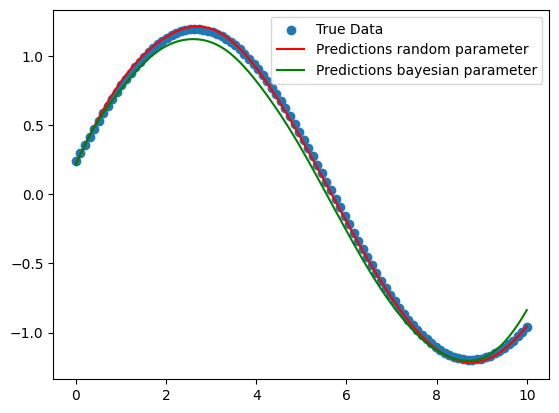

In [17]:
#Look at performance on test data
X = test["X"]

y_pred_rand = model_optimized_rand(X).squeeze(-1)
y_pred_bayes = model_optimized_bayes(X).squeeze(-1)

n = 110 #defines which initial conditions we look at?
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test["t_tensor"][n], y_pred_rand.cpu().detach()[n], color="red", label="Predictions random parameter")
plt.plot(test["t_tensor"][n], y_pred_bayes.cpu().detach()[n], color="green", label="Predictions bayesian parameter")
plt.legend()
plt.show()

# K-fold 

In [18]:
#put train and validation together so K-fold can do its work
data = {
    'args_tensor': torch.cat([train['args_tensor'], validation['args_tensor']], dim=0),
    'x0_tensor':   torch.cat([train['x0_tensor'],   validation['x0_tensor']],   dim=0),
    't_tensor':    torch.cat([train['t_tensor'],    validation['t_tensor']],    dim=0),
    'y_tensor':    torch.cat([train['y_tensor'],    validation['y_tensor']],    dim=0),
    'X':           torch.cat([train['X'],           validation['X']],           dim=0),
}

K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)
fold_losses = []

for train_idx, val_idx in kf.split(data['args_tensor']):
    # Slice each tensor in the dictionary
    train_fold = {k: v[train_idx].to(device) for k, v in data.items()}
    val_fold   = {k: v[val_idx].to(device)   for k, v in data.items()}

    # Initialize model with best hyperparameters
    model = HarmonicModel(n_in=4,
                          hidden_sizes=best_params['hidden_sizes'],
                          activation=best_params['activation']).to(device)

    # Train model on this fold
    train_harmonic(model, lr=best_params['lr'], epochs=100, data=train_fold)
    loss_val = evaluate_harmonic(model, data=val_fold)
    fold_losses.append(loss_val)

average_cv_loss = sum(fold_losses) / K
print("Estimated generalization loss (K-Fold CV):", average_cv_loss)


Epoch 100/100, Loss: 0.0432
Epoch 100/100, Loss: 0.0328
Epoch 100/100, Loss: 0.0567
Epoch 100/100, Loss: 0.0218
Epoch 100/100, Loss: 0.0282
Estimated generalization loss (K-Fold CV): 0.03611438125371933


# Test the model on noisy data

In [19]:
def add_noise_to_dataset(dataset, tensor_keys=['y_tensor'], noise_std=0.05, seed=None):
    """
    Add Gaussian noise to specified tensors in a dataset.

    Args:
        dataset (dict): Dictionary of tensors, e.g., {'y_tensor': ..., 't_tensor': ...}
        tensor_keys (list): Which tensors to add noise to (usually target/output tensors)
        noise_std (float): Standard deviation of Gaussian noise
        seed (int, optional): Random seed for reproducibility
    Returns:
        noisy_dataset (dict): Copy of dataset with added noise
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    noisy_dataset = {k: v.clone() for k, v in dataset.items()}  # copy original tensors
    
    for key in tensor_keys:
        noisy_dataset[key] += torch.randn_like(dataset[key]) * noise_std
    
    return noisy_dataset


In [20]:
#Noisy data (create only 1 set to check the model performances)
train_no_noise, validation_no_noise, test_no_noise = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1, [0.5, 0.2, 0.3], "RK45", device=device, seed=0)

# Example: add noise with std=0.1 to y_tensor
noise_std = 0.5
train_noise = add_noise_to_dataset(train_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)
validation_noise = add_noise_to_dataset(validation_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)
test_noise = add_noise_to_dataset(test_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)

# test dataset bayes
X = test_noise["X"]
y_pred_noise = best_model(X).squeeze(-1)


test_loss_bayes_noise = evaluate_harmonic(best_model, data=test_noise)
print(f"Test Loss Random optimization: {test_loss_bayes_noise:.4f}")

Test Loss Random optimization: 0.1959


/tmp/ipykernel_1101/1405275027.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio_an_num = (test_no_noise["y_tensor"][n][0:, 0]/sol.y[0])[::slice]


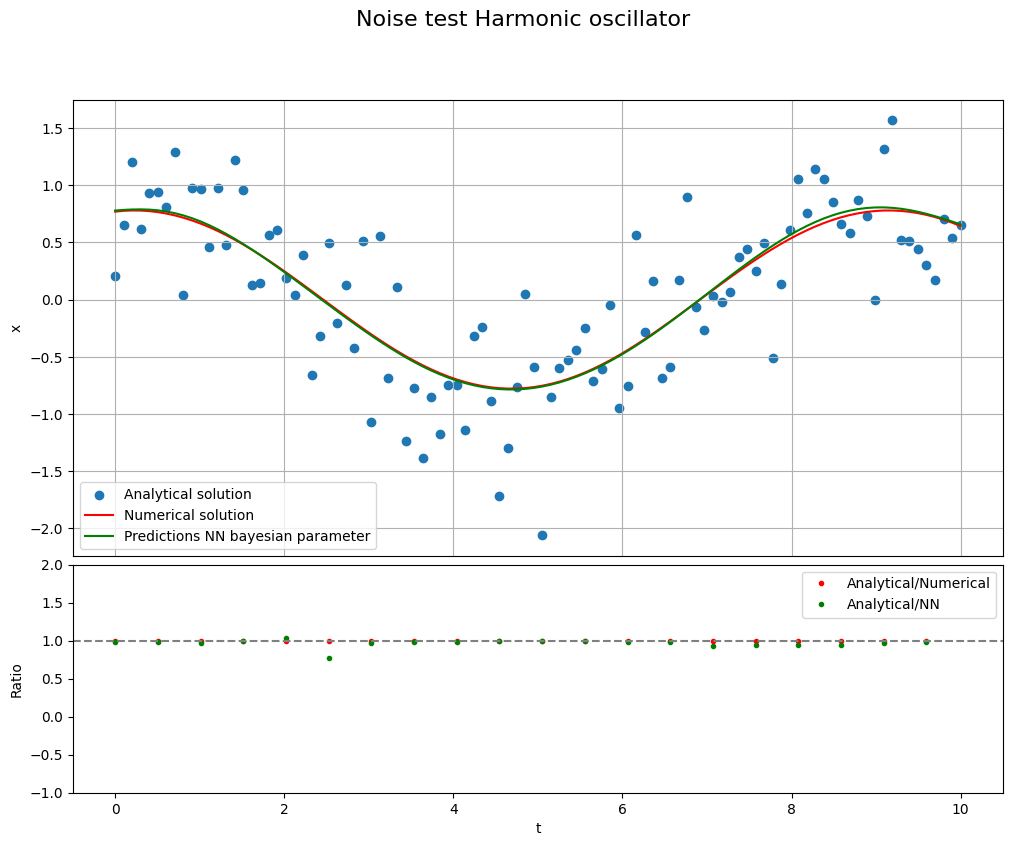

In [21]:
n = 0

y_pred_noise.to("cpu")
test_noise["t_tensor"].to("cpu")

#Solve numerically
y0 = [test_noise["x0_tensor"][n][0], test_noise["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_noise["t_tensor"][n][0], test_noise["t_tensor"][n][-1]
w = test_noise["args_tensor"][n]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_noise["t_tensor"][n], method='RK45', args=(w))

# Create figure with GridSpec
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.025)

#create ratios for lower plot
slice = 5
ratio_an_num = (test_no_noise["y_tensor"][n][0:, 0]/sol.y[0])[::slice]
ratio_an_NN = (test_no_noise["y_tensor"][n][0:, 0]/y_pred_noise.cpu().detach()[n])[::slice]

# Main plot
ax_main = fig.add_subplot(gs[0])
ax_main.scatter(test_noise["t_tensor"][n], test_noise["y_tensor"][n][0:, 0], label="Analytical solution") #analytical
ax_main.plot(sol.t, sol.y[0], label='Numerical solution', color = 'red') #numerical
ax_main.plot(test_noise["t_tensor"][n], y_pred_noise.cpu().detach()[n], color="green", label="Predictions NN bayesian parameter") #NN ML
ax_main.set_ylabel('x')
ax_main.legend()
ax_main.grid(True)
ax_main.tick_params(bottom=False)  # remove x-axis ticks for main plot

# Ratio / comparison plot
ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_num, '.', label='Analytical/Numerical', color='red')
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_NN, '.', label='Analytical/NN', color='green')
ax_ratio.axhline(1, color='gray', linestyle='--')
ax_ratio.set_xlabel('t')
ax_ratio.set_ylabel('Ratio')
ax_ratio.set_ylim(-1, 2)
ax_ratio.legend()

fig.suptitle("Noise test Harmonic oscillator", fontsize=16)
plt.show()

# Test generalization

In [22]:
#Generalization
train_generalization, validation_generalization, test_generalization = create_trainig_validation_test_set(harmonic_osc, (0, 50), 100, 1, [0.5, 0.2, 0.3], "RK45", device=device, seed=0)
# test dataset bayes
X = test_generalization["X"]
y_pred_generalization = best_model(X).squeeze(-1)


test_loss_bayes_generalization = evaluate_harmonic(best_model, data=test_generalization)
print(f"Test Loss Random optimization: {test_loss_bayes_generalization:.4f}")

Test Loss Random optimization: 1.2228


/tmp/ipykernel_1101/2674055991.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio_an_num = (test_generalization["y_tensor"][n][0:, 0]/sol.y[0])[::slice]


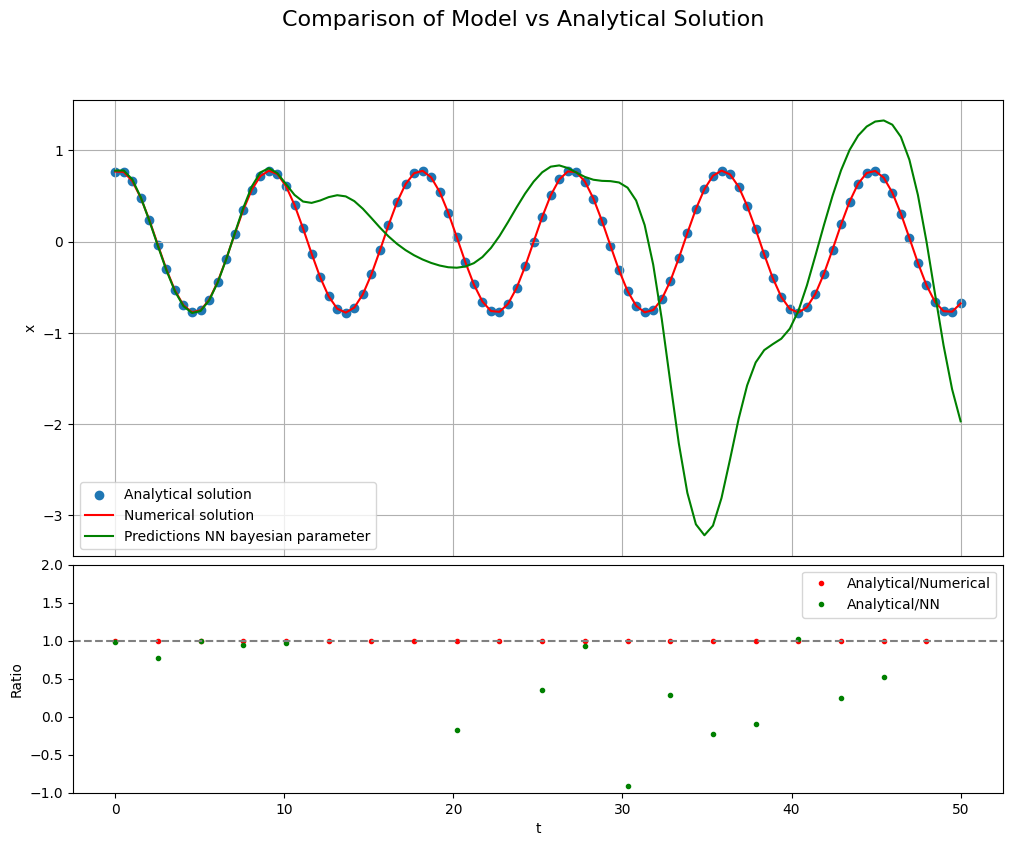

In [23]:
n = 0

y_pred_generalization.to("cpu")
test_generalization["t_tensor"].to("cpu")

#Solve numerically
y0 = [test_generalization["x0_tensor"][n][0], test_generalization["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_generalization["t_tensor"][n][0], test_generalization["t_tensor"][n][-1]
w = test_generalization["args_tensor"][n]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_generalization["t_tensor"][n], method='RK45', args=(w))

# Create figure with GridSpec
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.025)

#create ratios for lower plot
slice = 5
ratio_an_num = (test_generalization["y_tensor"][n][0:, 0]/sol.y[0])[::slice]
ratio_an_NN = (test_generalization["y_tensor"][n][0:, 0]/y_pred_generalization.cpu().detach()[n])[::slice]

# Main plot
ax_main = fig.add_subplot(gs[0])
ax_main.scatter(test_generalization["t_tensor"][n], test_generalization["y_tensor"][n][0:, 0], label="Analytical solution") #analytical
ax_main.plot(sol.t, sol.y[0], label='Numerical solution', color = 'red') #numerical
ax_main.plot(test_generalization["t_tensor"][n], y_pred_generalization.cpu().detach()[n], color="green", label="Predictions NN bayesian parameter") #NN ML
ax_main.set_ylabel('x')
ax_main.legend()
ax_main.grid(True)
ax_main.tick_params(bottom=False)  # remove x-axis ticks for main plot

# Ratio / comparison plot
ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_num, '.', label='Analytical/Numerical', color='red')
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_NN, '.', label='Analytical/NN', color='green')
ax_ratio.axhline(1, color='gray', linestyle='--')
ax_ratio.set_xlabel('t')
ax_ratio.set_ylabel('Ratio')
ax_ratio.set_ylim(-1, 2)
ax_ratio.legend()

fig.suptitle("Comparison of Model vs Analytical Solution", fontsize=16)
plt.show()

# Test physical quantities

### Energy conservation

Initial energy E0 = 1.500872e-01
Max absolute deviation = 2.422459e+00
Max relative deviation = 1.614034e+01


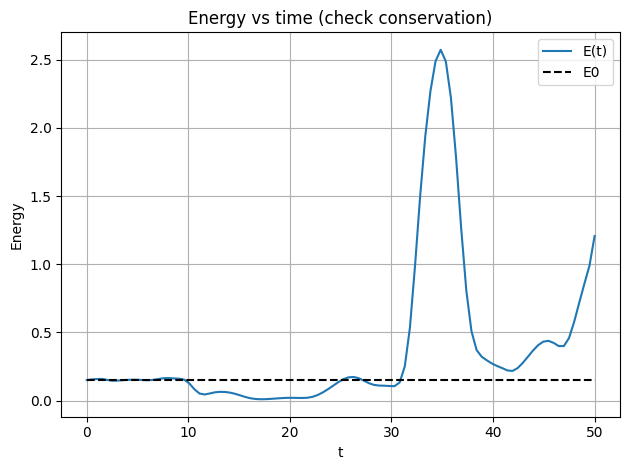

In [24]:
n = 0  # choose trajectory index

# Position
x = y_pred_generalization[n].detach().cpu().numpy()

# Time
t = test_generalization["t_tensor"][n].detach().cpu().numpy()

# Velocity via finite difference
v = np.gradient(x, t)

#Energy conservation (check on generalized data)
E_t = 0.5 * v**2 + 0.5 * float(w) * x**2
E0 = E_t[0]

# diagnostics
abs_dev = np.max(np.abs(E_t - E0))
rel_dev = np.max(np.abs((E_t - E0) / E0))

print(f"Initial energy E0 = {E0:.6e}")
print(f"Max absolute deviation = {abs_dev:.6e}")
print(f"Max relative deviation = {rel_dev:.6e}")

plt.plot(test_generalization["t_tensor"][n], E_t, label='E(t)')
plt.hlines(E0, sol.t[0], sol.t[-1], colors='k', linestyles='dashed', label='E0')
#plt.ylim(0,2)
plt.xlabel('t')
plt.ylabel('Energy')
plt.title('Energy vs time (check conservation)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [49]:
#Computation time
N = 100
timesteps_NN = np.zeros(N)
timesteps_Num = np.zeros(N)
N_list = np.arange(0,N)

#NN
X = test["X"]

for i, el in tqdm(enumerate(N_list), desc="Computation time NN: "):
    begin = time.perf_counter()
    for _ in range(el):
        best_model(X)
    end = time.perf_counter()
    timesteps_NN[i] = end-begin

#Numerical
for i, el in tqdm(enumerate(N_list), desc="Computation time Numerical: "):
    begin = time.perf_counter()
    for _ in range(el):
        sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test["t_tensor"][n], method='RK45', args=(w))
    end = time.perf_counter()
    timesteps_Num[i] = end-begin

Computation time NN: : 100it [03:04,  1.85s/it]
Computation time Numerical: : 100it [00:47,  2.12it/s]


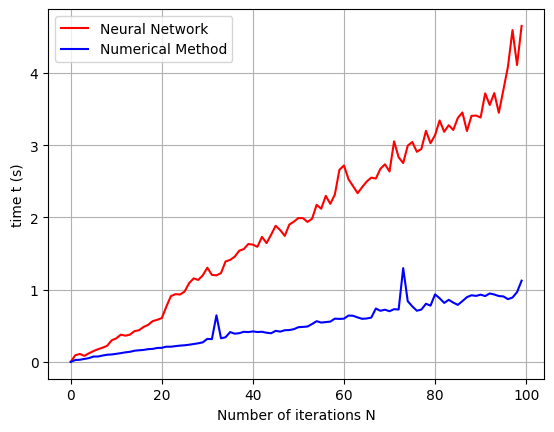

In [50]:
#Plot computational time
plt.plot(N_list, timesteps_NN, color='red', label="Neural Network")
plt.plot(N_list, timesteps_Num, color='blue', label="Numerical Method")
plt.xlabel("Number of iterations N")
plt.ylabel("time t (s)")
plt.grid(True)
plt.legend()
plt.show()

# TO DO

- Test physical quantities of model
- Make sure both models are comparable
- Compare both models